In [73]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score

In [34]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [35]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [36]:
def visualize_clusters(X, labels):
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels,
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)

    for label in unique_labels:
        center = X[labels == label].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

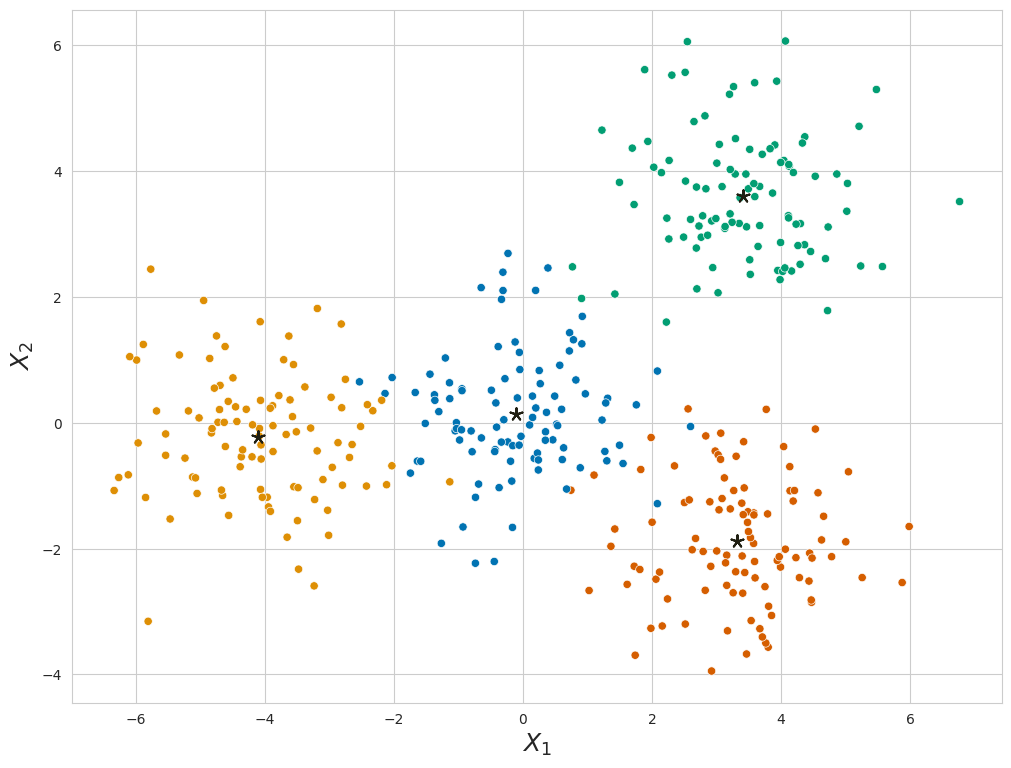

In [37]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [38]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """

        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize


    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        n_samples, n_features = X.shape

        # Инициализация центров кластеров
        if self.init == "random":
            self.centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), size=self.n_clusters, replace=False)
            self.centroids = X[centroids_idx]

        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = [self._calculate_distance(X, centroid) for centroid in self.centroids]
            dists = np.vstack(dists).T

            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)

            # Пересчитаем центр масс для каждого кластера
            new_centroids = np.array([X[cluster_labels == i].mean(axis=0) for i in range(self.n_clusters)])

            # Проверка на сходимость: если центроиды не изменились, завершаем алгоритм
            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids

            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()

        return self

    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        dists = np.array([self._calculate_distance(X, centroid) for centroid in self.centroids])
        cluster_labels = np.argmin(dists, axis=0)
        return cluster_labels

    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        dist = np.sqrt(((X - centroid) ** 2).sum(axis=1))
        return dist

    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

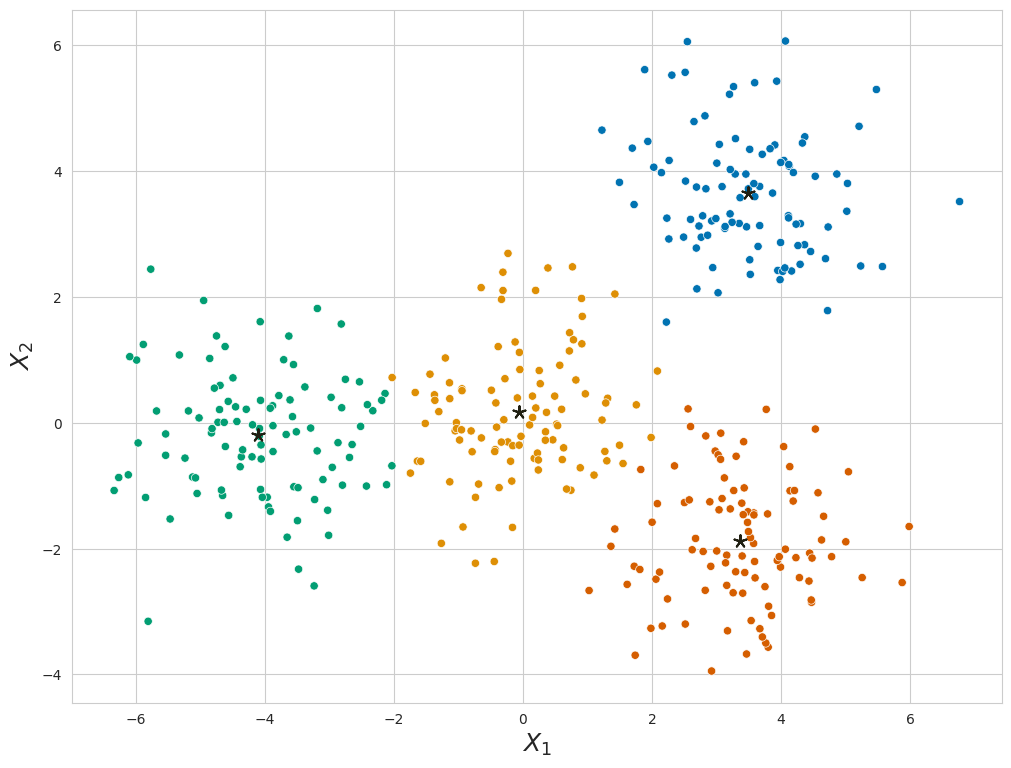

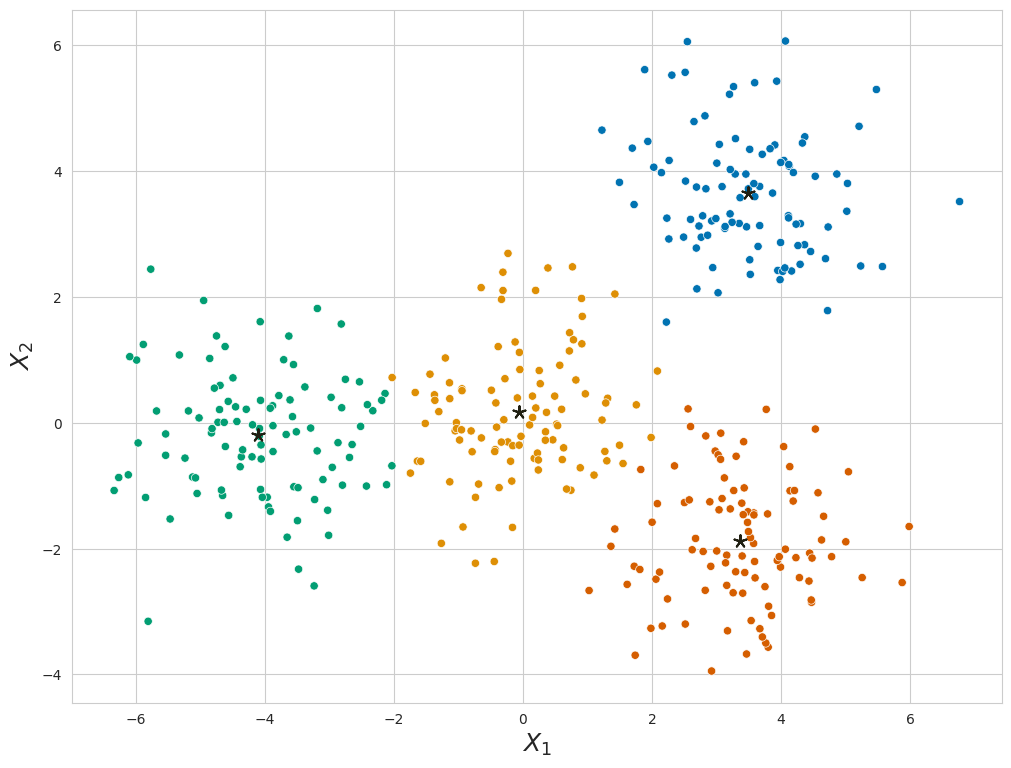

In [39]:
# Создание экземпляра MyKMeans
my_kmeans = MyKMeans(n_clusters=4, init="random", max_iter=300, visualize=True)
# Обучение MyKMeans
my_kmeans.fit(X)
# Использование метода predict для определения кластеров
cluster_labels = my_kmeans.predict(X)
# Визуализация результатов
visualize_clusters(X, cluster_labels)

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [44]:
data = load_digits()
X, y = data.data, data.target

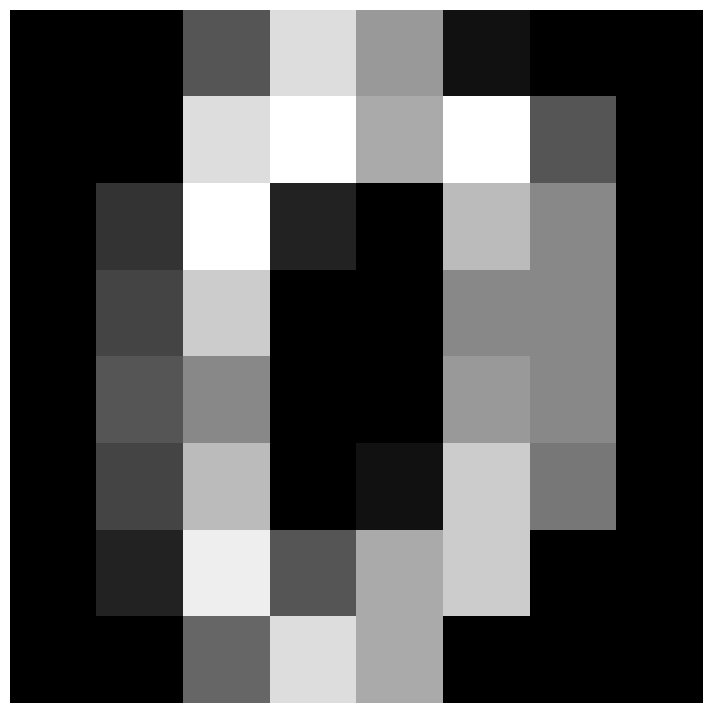

In [77]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

##### YOUR TURN TO CODE

In [57]:
def algorithm_selection(X, y, distances, algorithms, metrics):
    """
    Для заданных алгоримов кластеризации и гиперпараметров
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    results = []

    for distance in distances:
         for algorithm in algorithms:
            # Инициализация и применение агломеративной кластеризации
            model = AgglomerativeClustering(linkage=algorithm, affinity=distance)
            labels = model.fit_predict(X)

            # Расчет метрик качества
            result = {
                'distance': distance,
                'linkage': algorithm,
                'homogeneity': homogeneity_score(y, labels) if 'Homogeneity' in metrics else None,
                'completeness': completeness_score(y, labels) if 'Completeness' in metrics else None,
                'v_measure': v_measure_score(y, labels) if 'V-measure' in metrics else None,
                'silhouette': silhouette_score(X, labels, metric=distance) if 'Silhouette' in metrics else None,
            }
            results.append(result)

    # Создание DataFrame из результатов
    compare_dataframe = pd.DataFrame(results)
    return compare_dataframe

# Параметры для функции algorithm_selection
distances = ['euclidean', 'manhattan', 'cosine', 'chebyshev']
linkages = ['average', 'single', 'complete']
metrics = ['Homogeneity', 'Completeness', 'V-measure', 'Silhouette']
# Вызов функции algorithm_selection
compare_dataframe = algorithm_selection(X, y, distances, linkages, metrics)
# Вывод результата
compare_dataframe

,distance,linkage,homogeneity,completeness,v_measure,silhouette
0,euclidean,average,0.000558,0.271853,0.001114,0.111356
1,euclidean,single,0.000565,0.275198,0.001128,-0.002273
2,euclidean,complete,0.165209,0.549408,0.254031,0.080896
3,manhattan,average,0.030062,0.376695,0.055681,0.111486
4,manhattan,single,0.000565,0.275198,0.001128,0.003094
5,manhattan,complete,0.052011,0.357351,0.090805,0.093063
6,cosine,average,0.000558,0.271853,0.001114,0.248548
7,cosine,single,0.000565,0.275198,0.001128,0.022960
8,cosine,complete,0.040045,0.349389,0.071854,0.150013
9,chebyshev,average,0.252646,0.954572,0.399545,0.040060


Из таблицы видно, что разные комбинации методов и метрик дали разные результаты:

**Chebyshev + Average** вышли вперед по точности кластеров, но границы между кластерами получились не очень четкими.

**Euclidean + Complete** дал неплохой баланс между точностью и полнотой кластеров, хороший вариант для компромисса.

**Cosine + Average** показал лучший результат по четкости разделения кластеров, если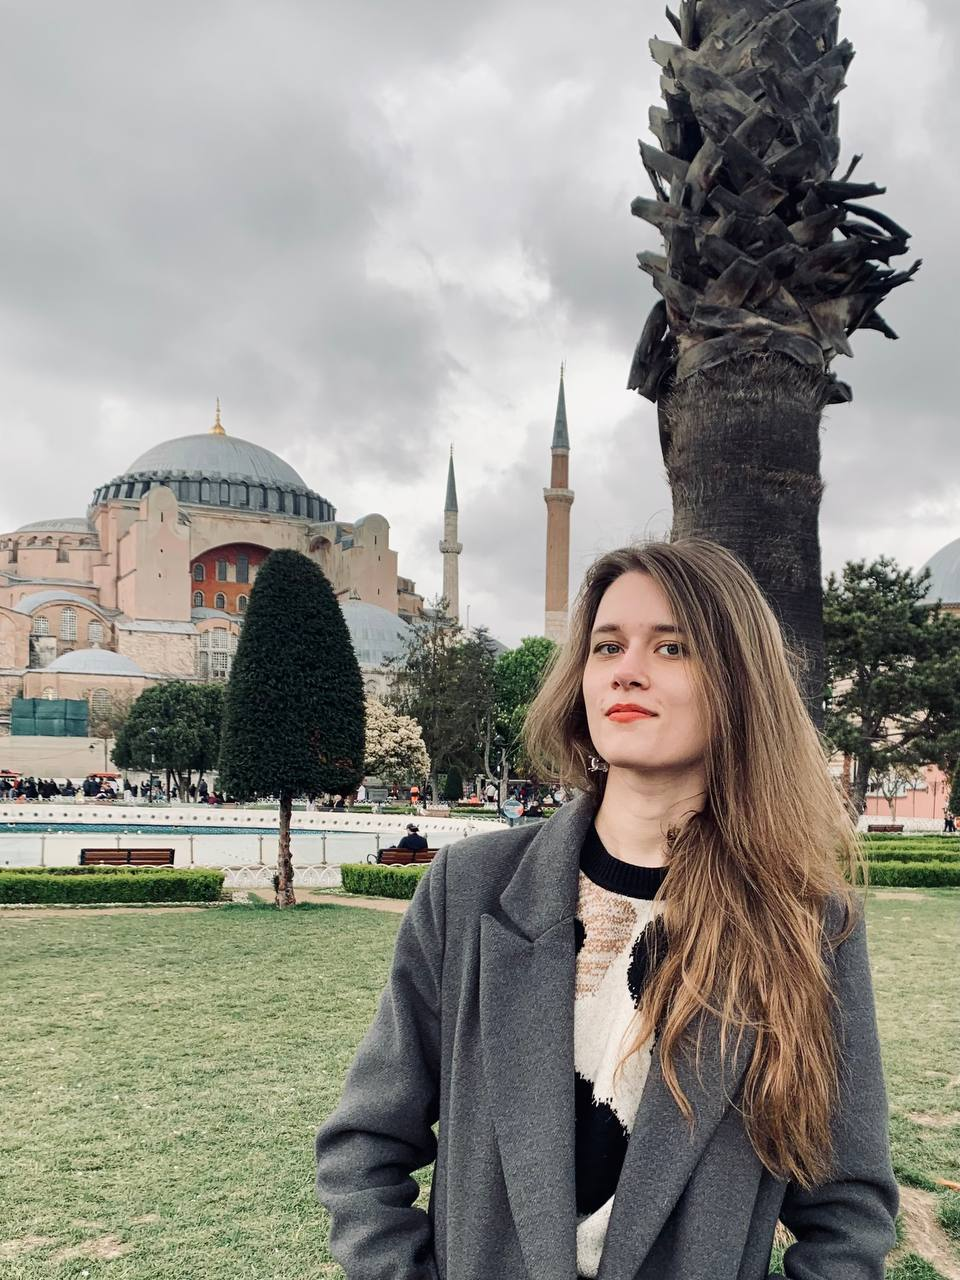 важно, чтобы кластеры были хорошо разделены и плотные.

**Manhattan + Average** тоже хорошо справился с разделением кластеров, можно рассмотреть, если важна четкость границ.

В общем, всё зависит от того, что важнее: точность кластеров, их полнота или четкость границ

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [59]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)
# Вывод первых нескольких строк данных для предварительного просмотра
fc_data.head()

,FSC-A,SSC-A,HLA-DR,CD3,CD45,CD14,CD56,CD19,CD11c
0,0.722199,0.154232,0.494449,0.512853,4.057328,1.019255,4.007273,-1.406912,0.384406
1,0.751073,0.114618,4.671924,0.822042,4.933149,0.159388,-0.216407,6.034845,0.577039
2,1.108188,0.150011,-0.422857,4.006353,5.616384,0.519223,0.783077,-0.318668,-0.493832
3,0.553310,0.119929,0.345968,3.332310,5.260935,1.481229,0.264846,0.694883,3.416960
4,0.774884,0.076984,4.984963,0.885501,4.562367,0.217117,0.086279,5.563345,0.471591


##### YOUR TURN TO CODE:

              FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.35870

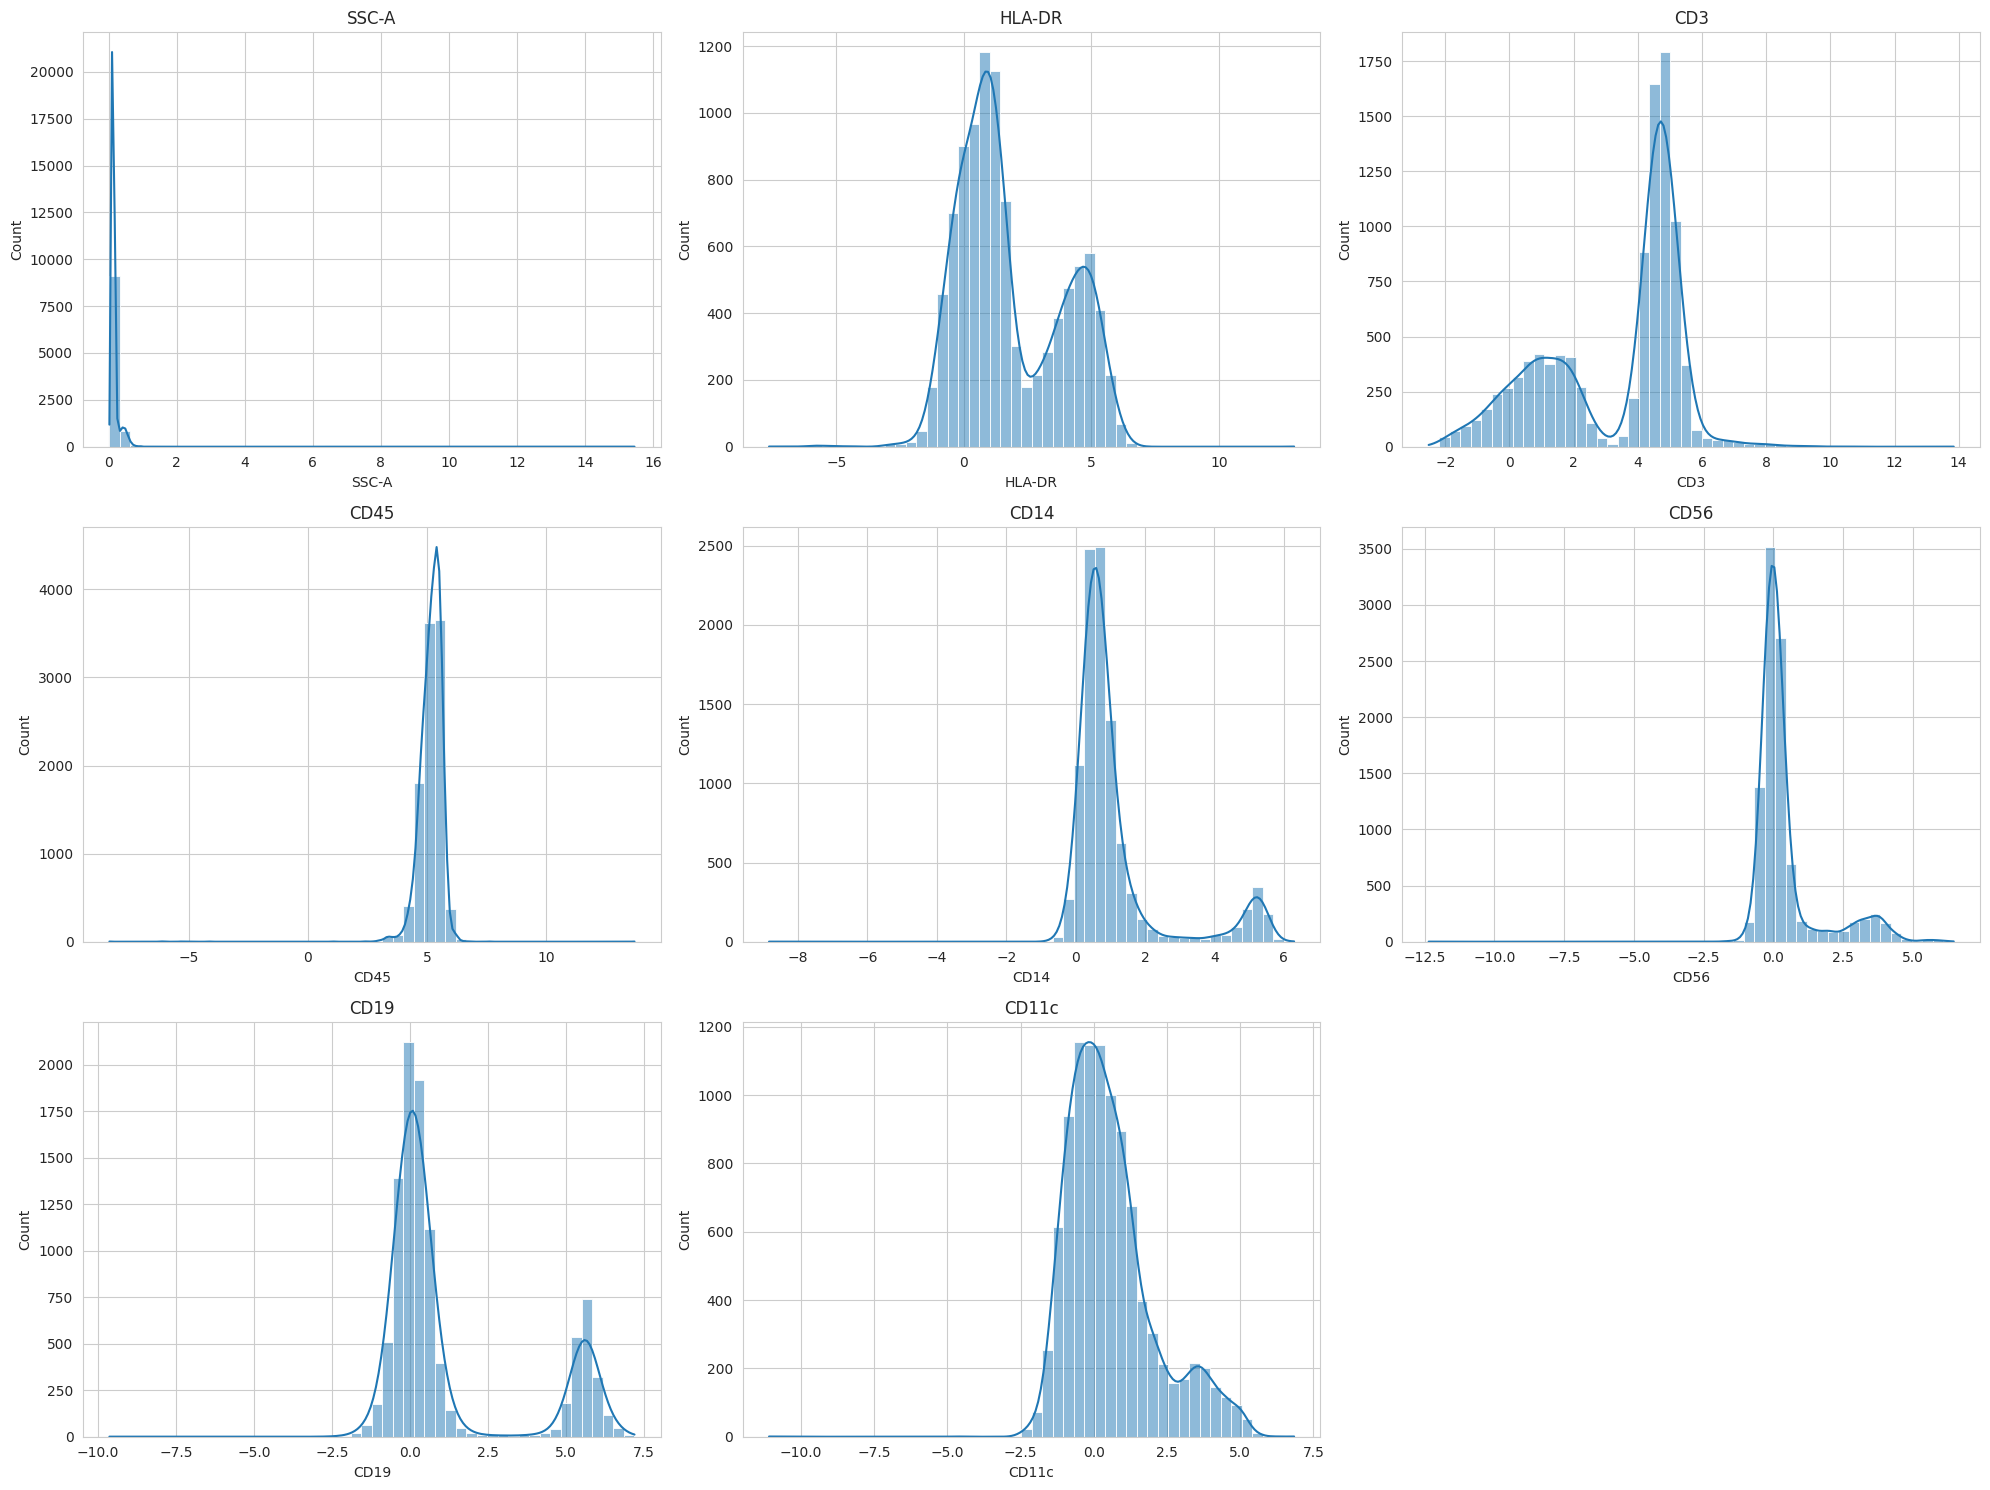

In [63]:
# Основные статистические показатели датасета
fc_data_description = fc_data.describe()
# Количество клеток и признаков
num_cells = fc_data.shape[0]
num_features = fc_data.shape[1] - 1  # Исключаем столбец 'Unnamed: 0'
print(fc_data_description, num_cells, num_features)
# Настройка размера графиков
plt.figure(figsize=(20, 15))
# Итерация по признакам для визуализации гистограмм
for i, column in enumerate(fc_data.columns[1:], 1):  # Пропускаем 'Unnamed: 0'
    plt.subplot(3, 3, i)
    sns.histplot(fc_data[column], bins=50, kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [64]:
def plot_tsne(data, n_iter=1000,
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity:
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """

    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)

    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа,
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)

    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)

    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными

    return tsne_embedding

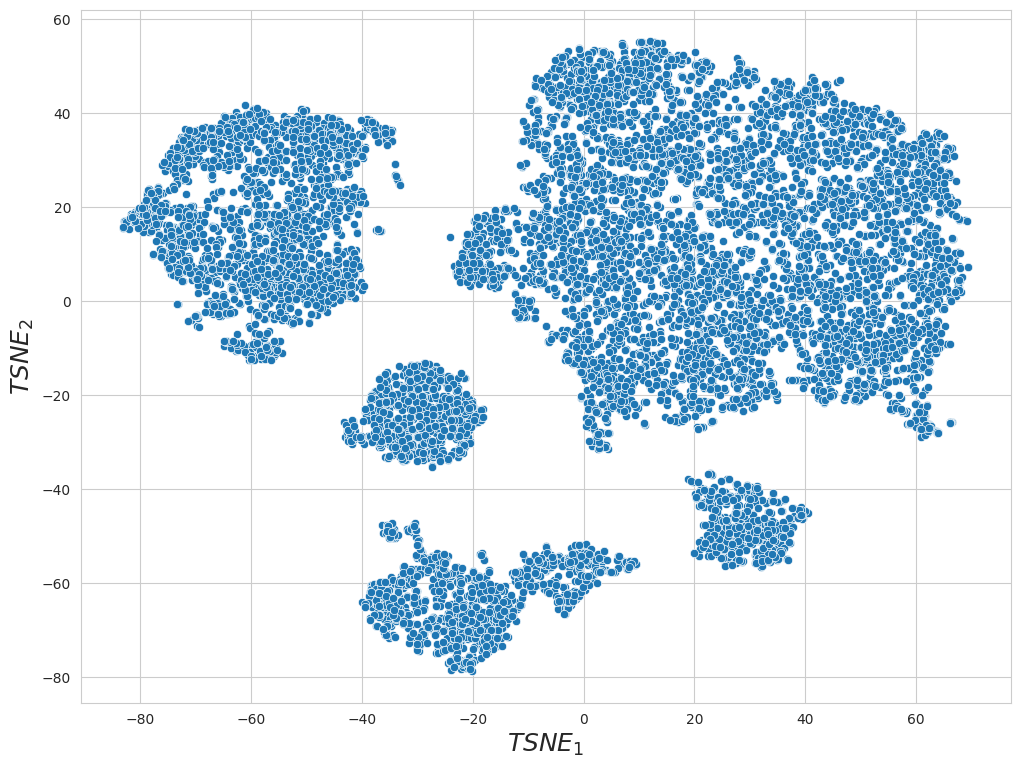

In [65]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

K-Means silhouette_score: 0.6101
DBSCAN silhouette_score: -0.4732
Agglomerative Clustering silhouette_score: 0.6114
Лучший метод: Agglomerative


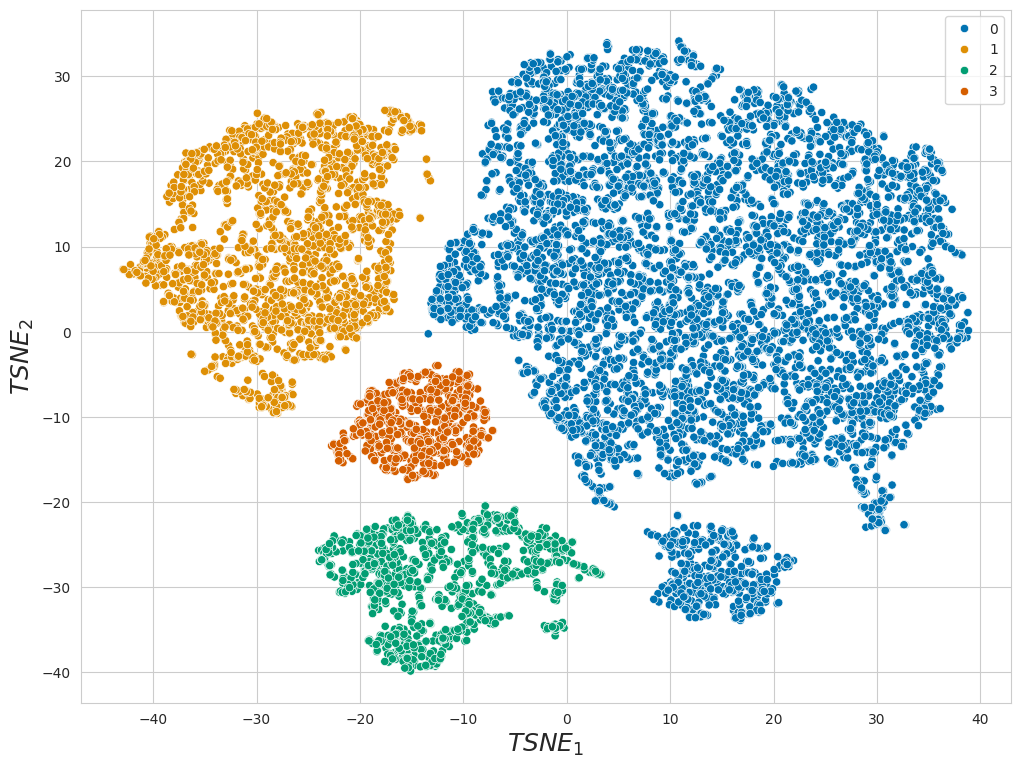

In [98]:
# Функция для кластеризации и оценки silhouette_score
def cluster_and_evaluate(fc_data, cluster_method, **kwargs):
    # Кластеризация
    labels = cluster_method(**kwargs).fit_predict(fc_data)
    # Оценка с помощью silhouette_score
    silhouette_avg = silhouette_score(fc_data, labels)
    return labels, silhouette_avg

# K-Means
kmeans_labels, kmeans_silhouette = cluster_and_evaluate(fc_data, KMeans, n_clusters=4, random_state=42)
print(f"K-Means silhouette_score: {kmeans_silhouette:.4f}")

# DBSCAN кластеризация
dbscan_labels, dbscan_silhouette = cluster_and_evaluate(fc_data, DBSCAN, eps=0.5, min_samples=5)
print(f"DBSCAN silhouette_score: {dbscan_silhouette:.4f}")

# Agglomerative Clustering
agglo_labels, agglo_silhouette = cluster_and_evaluate(fc_data, AgglomerativeClustering, n_clusters=4)
print(f"Agglomerative Clustering silhouette_score: {agglo_silhouette:.4f}")

# Выбор лучшего метода на основании silhouette_score
best_method = "K-Means" if max(kmeans_silhouette, dbscan_silhouette, agglo_silhouette) == kmeans_silhouette else ("DBSCAN" if max(dbscan_silhouette, agglo_silhouette) == dbscan_silhouette else "Agglomerative")
best_labels = kmeans_labels if best_method == "K-Means" else (dbscan_labels if best_method == "DBSCAN" else agglo_labels)

print(f"Лучший метод: {best_method}")

# Визуализация результатов лучшего метода с использованием t-SNE
tsne_embedding = plot_tsne(fc_data, n_iter=500, perplexity=30, color=best_labels)


Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Да, см. выше

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

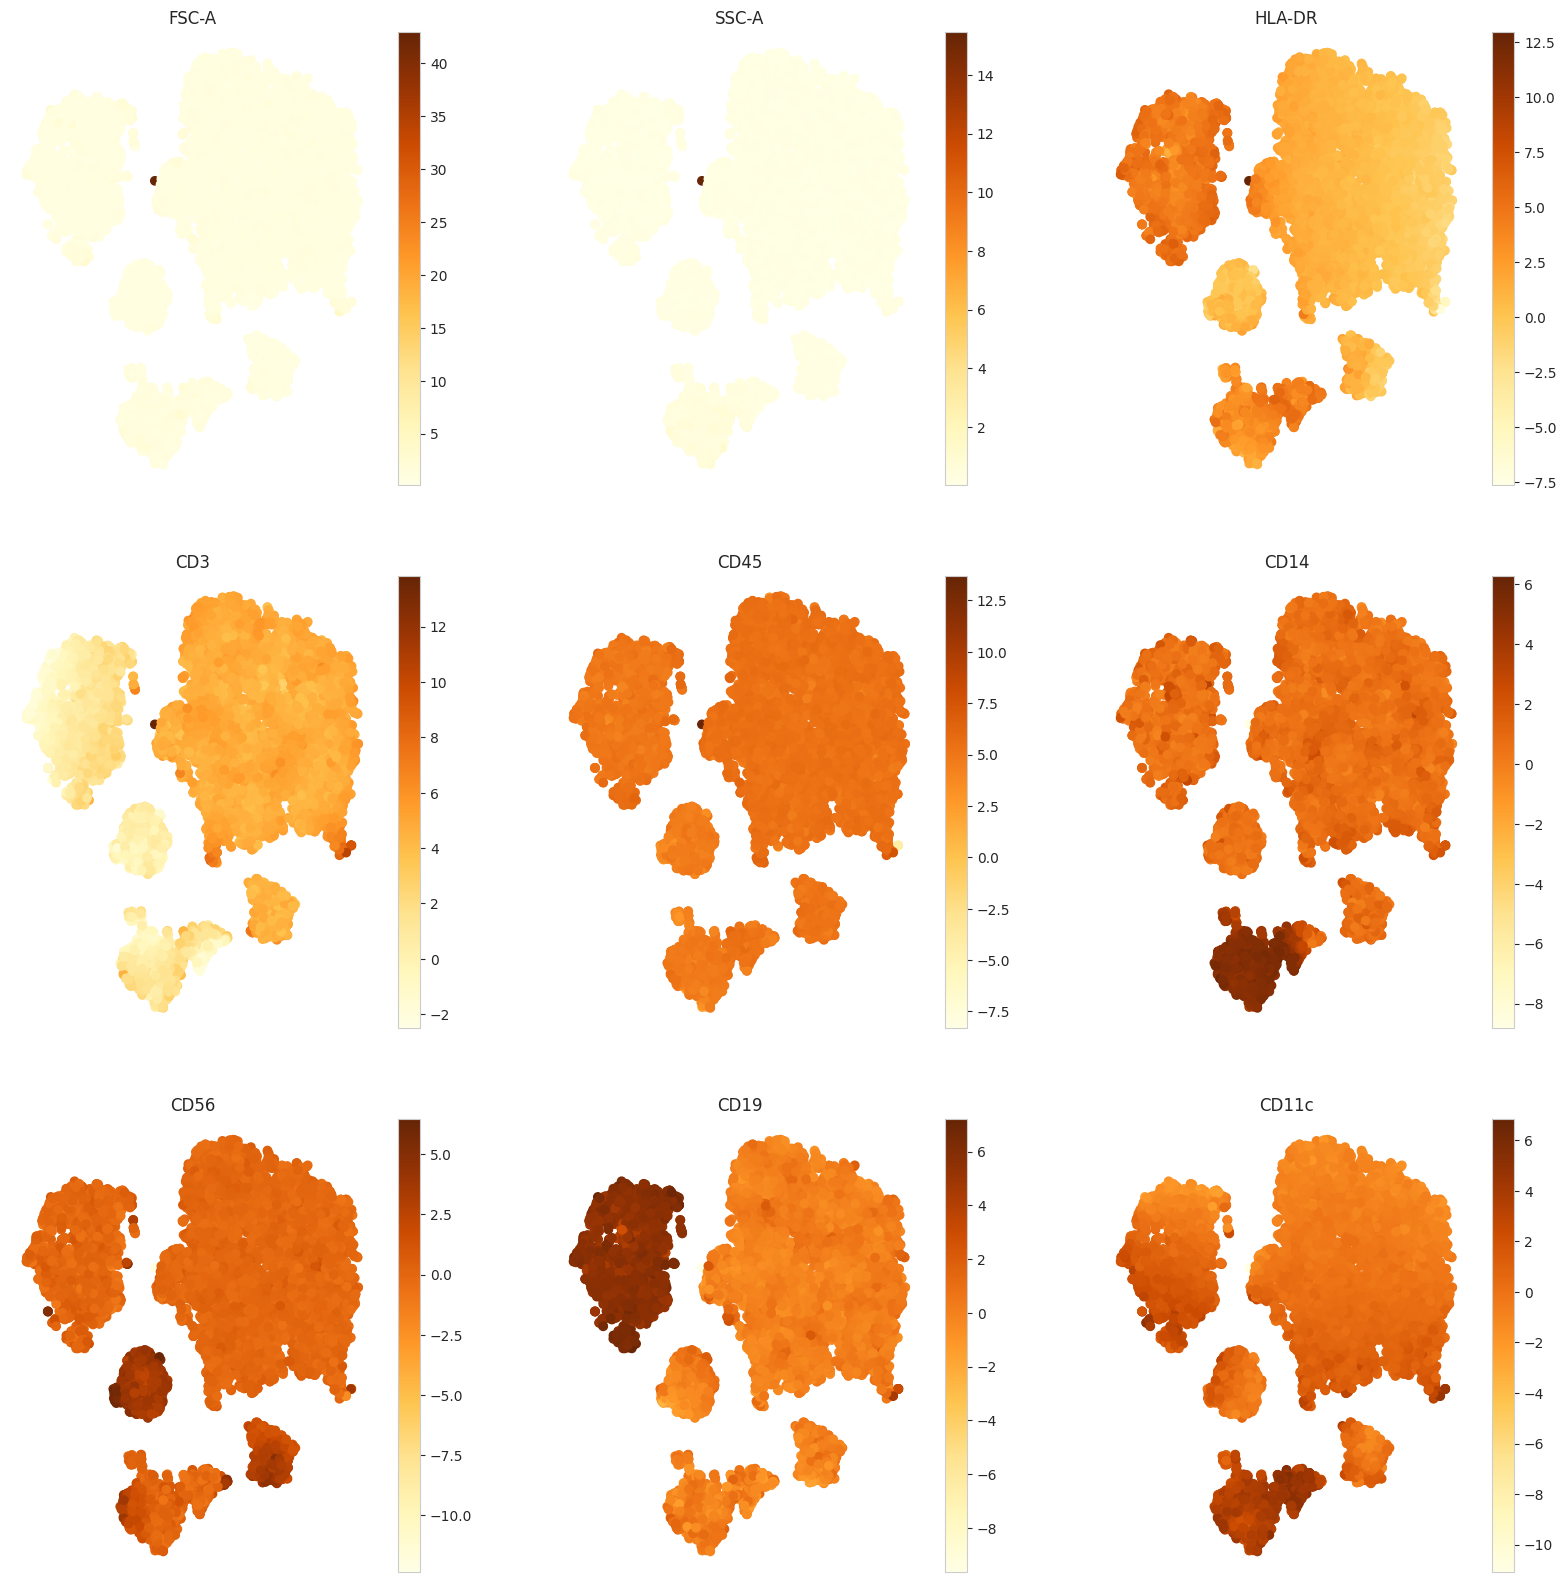

In [99]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1],
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

Кластер с высокой экспрессией CD19 считаем B-клетками.

Кластер с высокой экспрессией CD3 считаем T-клетками.

Кластер с высокой экспрессией CD14 считаем моноцитами.

Оставшийся кластер считаем "Другими клетками".

In [102]:
cell_type_cluster_map = {1: "T_cells",
                         0: "B_cells",
                         2: "Monocytes",
                         3: "Other cells"}

In [103]:
labeled_fc_data = fc_data.assign(Population=kmeans_labels)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [104]:
cell_type_distribution = labeled_fc_data["Population"].value_counts()
print(cell_type_distribution)

T_cells        6201
B_cells        2035
Other cells    1091
Monocytes       673
Name: Population, dtype: int64


Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [105]:
labeled_fc_data.to_csv("data/labeled_fc_data.csv", index=False)

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Создаем целевую переменную 'y' и набор признаков 'X'
X = fc_data
y = best_labels

# Деление данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Сбалансируем классы
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                     y_train[y_train == 1],
                                     replace=True,
                                     n_samples=X_train[y_train == 0].shape[0],
                                     random_state=42)

# Объединяем с оригинальным большинством классов
X_train_balanced = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_balanced = np.hstack((y_train[y_train == 0], y_upsampled))

# Обучение классификатора на сбалансированных данных
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Предсказания на тестовой выборке
y_pred = clf.predict(X_test)

# Оценка качества модели с использованием f1_score
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.4693163739161952

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Я бы очень хотела съездить в Стамбул. Я была там в прошлом мае. Мне нравится этот город за его архитектуру. Виды с воды или с высоты холмов очень завораживают, хочется любоваться часами. Еще забавно везде встречать котов: в магазинах, ресторанах, в домах и т д.

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**